In [1]:
from rebroadcasted_blocks_vis import fetch_logs, retrieve_log
import json
import matplotlib
from ipywidgets import interact
import logging
import sys
import time

import networkx as nx
import matplotlib.pyplot as plt

class Context(object):
    def __init__(self, obj):
        self.obj = obj
        
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()

In [2]:

params = {
    "namespace": "regeneration",
    "hours_ago": 48,
    "cache_logs": True,
    "cache_file": "../../cached-logs.json",
    "in_file": None, #"../../cached-logs.json",
    "max_entries": 1000,
}

ctx = Context(params)


In [28]:

params = {
    "namespace": "bugspray",
    "hours_ago": 1,
    "cache_logs": False,
    "cache_file": "../../cached-logs.json",
    "in_file": "../../cached-logs.json",
    "max_entries": 150,
}

ctx = Context(params)


In [40]:
# Insert Cache Step Here

In [3]:
REBROADCAST_LOG_FILTER = ' "Rebroadcasting $state_hash" AND jsonPayload.metadata.state_hash:""'
rebroadcast_logs = fetch_logs(namespace=ctx.obj["namespace"], hours_ago=ctx.obj["hours_ago"], log_filter=REBROADCAST_LOG_FILTER, max_entries=ctx.obj["max_entries"])
logger.info(len(rebroadcast_logs))

INFO:root:Checking Logs for regeneration -- Past 48 Hours
INFO:root:Fetching 1000 Log Entries
INFO:root:Filter: 
 "Rebroadcasting $state_hash" AND jsonPayload.metadata.state_hash:""
INFO:root:57


In [4]:
RECEIVED_BLOCK_LOG_FILTER = ' "Received a block from $sender" AND jsonPayload.metadata.state_hash:""'
received_logs = fetch_logs(namespace=ctx.obj["namespace"], hours_ago=ctx.obj["hours_ago"], log_filter=RECEIVED_BLOCK_LOG_FILTER, max_entries=ctx.obj["max_entries"])
logger.info(len(received_logs))

INFO:root:Checking Logs for regeneration -- Past 48 Hours
INFO:root:Fetching 1000 Log Entries
INFO:root:Filter: 
 "Received a block from $sender" AND jsonPayload.metadata.state_hash:""
INFO:root:11


In [9]:
BROADCAST_LOG_FILTER = ' "Broadcasting new state over gossip net" AND jsonPayload.metadata.state_hash:""'
broadcast_logs = fetch_logs(namespace=ctx.obj["namespace"], hours_ago=ctx.obj["hours_ago"], log_filter=BROADCAST_LOG_FILTER, max_entries=ctx.obj["max_entries"])
logger.info(len(broadcast_logs))

INFO:root:Checking Logs for regeneration -- Past 48 Hours
INFO:root:Fetching 1000 Log Entries
INFO:root:Filter: 
 "Broadcasting new state over gossip net" AND jsonPayload.metadata.state_hash:""
INFO:root:19


In [10]:
rebroadcasting_block_logs = {}

nBlocks = 0
for entry in rebroadcast_logs:
    nBlocks += 1
#     if ctx.obj["in_file"] == None:
#         time.sleep(.04)
    if nBlocks % 100 == 0:
        logger.info(f"Processing {nBlocks}")
#     if nBlocks == ctx.obj["max_entries"]: 
#         break
    json_payload = entry[-1]
    labels = entry[1]
    message = json_payload["message"]
    metadata = json_payload["metadata"]
    try:
        #print(message)
        state_hash = metadata["state_hash"]
    # In case we get old incompatible logs
    except KeyError: 
        # EJECT!!
        print("EJECTING")
        continue

    if labels == None:
        print("EJECTING")
        continue
    
    if "Rebroadcasting" in message: 
        
        if state_hash in rebroadcasting_block_logs:
            rebroadcasting_block_logs[state_hash].append({**json_payload, **labels})
        else:
            rebroadcasting_block_logs[state_hash] = [{**json_payload, **labels}]

In [11]:
broadcasting_block_logs = {}
nBlocks = 0
for entry in broadcast_logs:
    nBlocks += 1
    if ctx.obj["in_file"] == None:
        time.sleep(.04)
    if nBlocks % 100 == 0:
        logger.info(f"Processing {nBlocks}")
    if nBlocks == ctx.obj["max_entries"]: 
        break

    json_payload = entry[-1]
    labels = entry[1]
    message = json_payload["message"]
    metadata = json_payload["metadata"]
    try:
        #print(message)
        state_hash = metadata["state_hash"]
    # In case we get old incompatible logs
    except KeyError: 
        # EJECT!!
        #print(json.dumps(metadata, indent=2))
        continue

    if labels == None:
        continue

    if "Broadcasting new state" in message: 
        if state_hash in broadcasting_block_logs:
            broadcasting_block_logs[state_hash].append({**json_payload, **labels})
        else:
            broadcasting_block_logs[state_hash] = [{**json_payload, **labels}]

In [12]:
received_block_logs = {}
nBlocks = 0
# Sort entries into Rebroadcast and Received logs
for entry in received_logs:  # API call(s)

    nBlocks += 1
    if nBlocks % 100 == 0:
        logger.info(f"Processing {nBlocks}")

    json_payload = entry[-1]
    labels = entry[1]
    message = json_payload["message"]
    metadata = json_payload["metadata"]
    try:
        #print(message)
        state_hash = metadata["state_hash"]
    # In case we get old incompatible logs
    except KeyError: 
        # EJECT!!
        #print(json.dumps(metadata, indent=2))
        continue

    if labels == None:
        continue

    if "Received" in message: 
        if state_hash in received_block_logs:
            received_block_logs[state_hash].append({**json_payload, **labels})
        else:
            received_block_logs[state_hash] = [{**json_payload, **labels}]
            
    


In [13]:
print(len(broadcasting_block_logs.keys()))
print(len(rebroadcasting_block_logs.keys()))
print(len(received_block_logs.keys()))


19
19
7


## Build the Graph

### Nodes
- Represent Daemon w/ a Peer id

### Edges
- Correspond to exactly two logs: Either a `Broadcast` or `Rebroadcast` log and a `Received` log
- Edges are weighted by the difference in timestamp for the log at either end, a proxy for "block latency" 

1
2
3
4
5
6
7
8


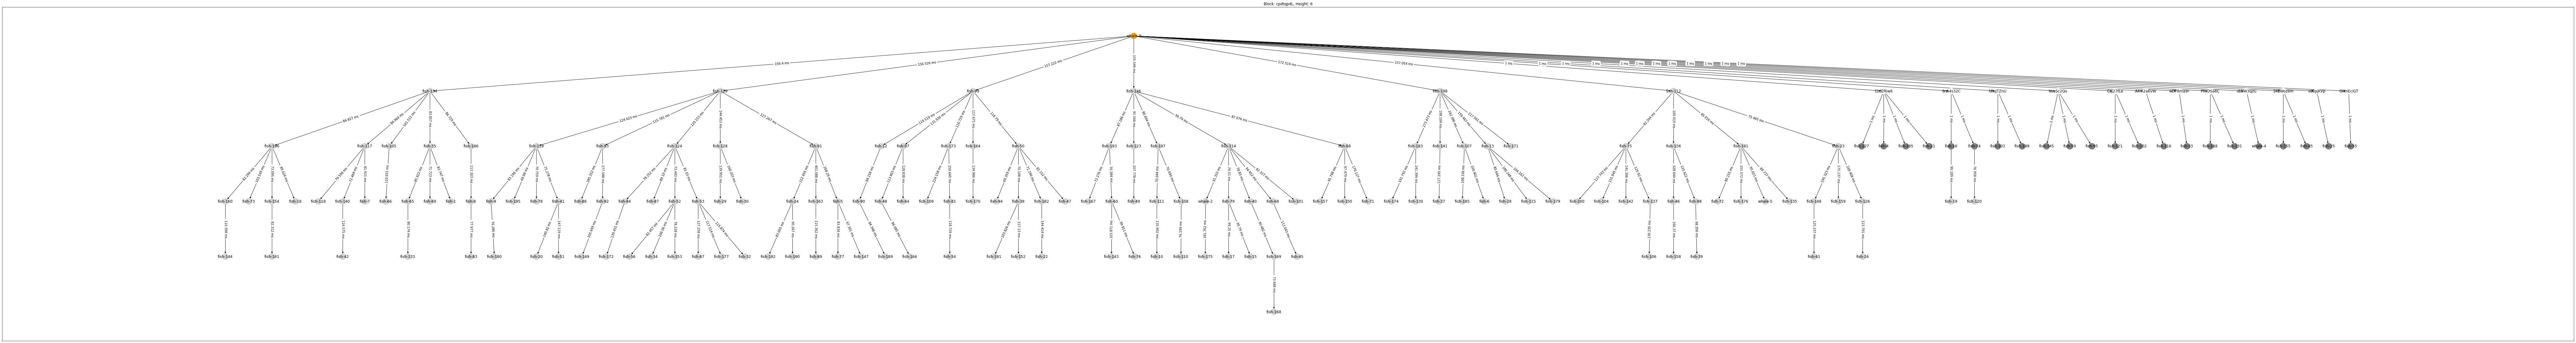

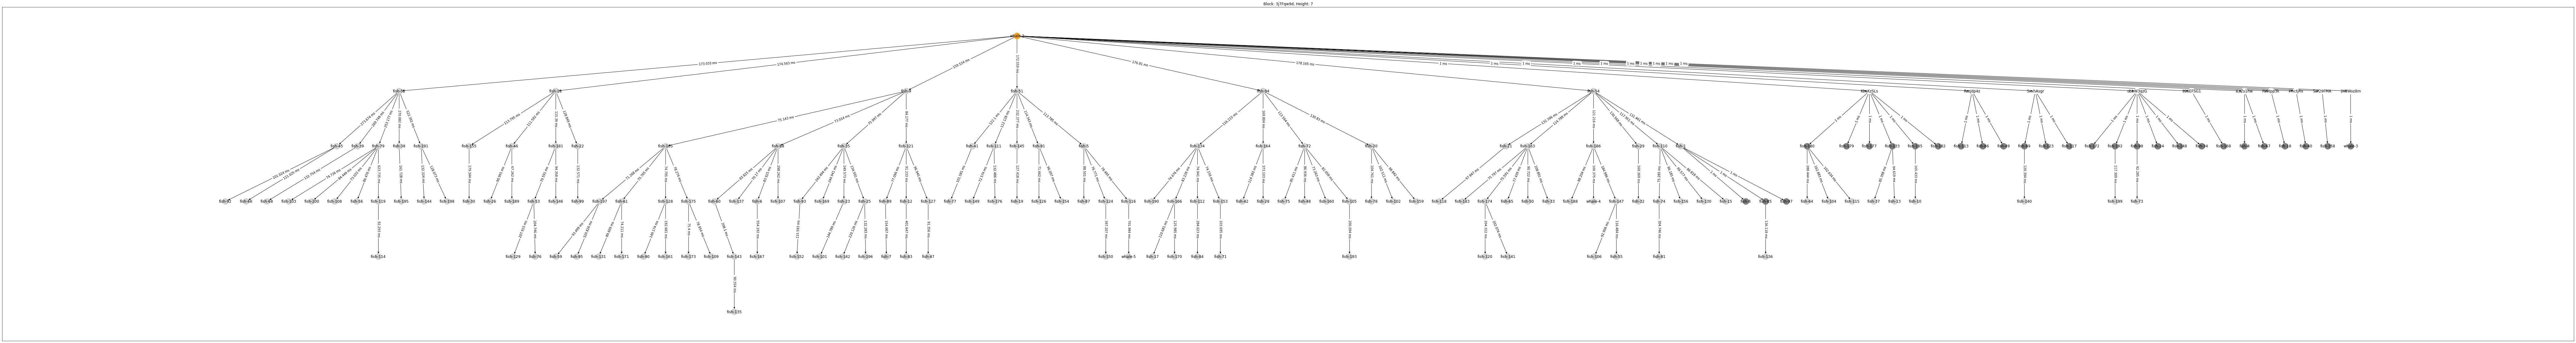

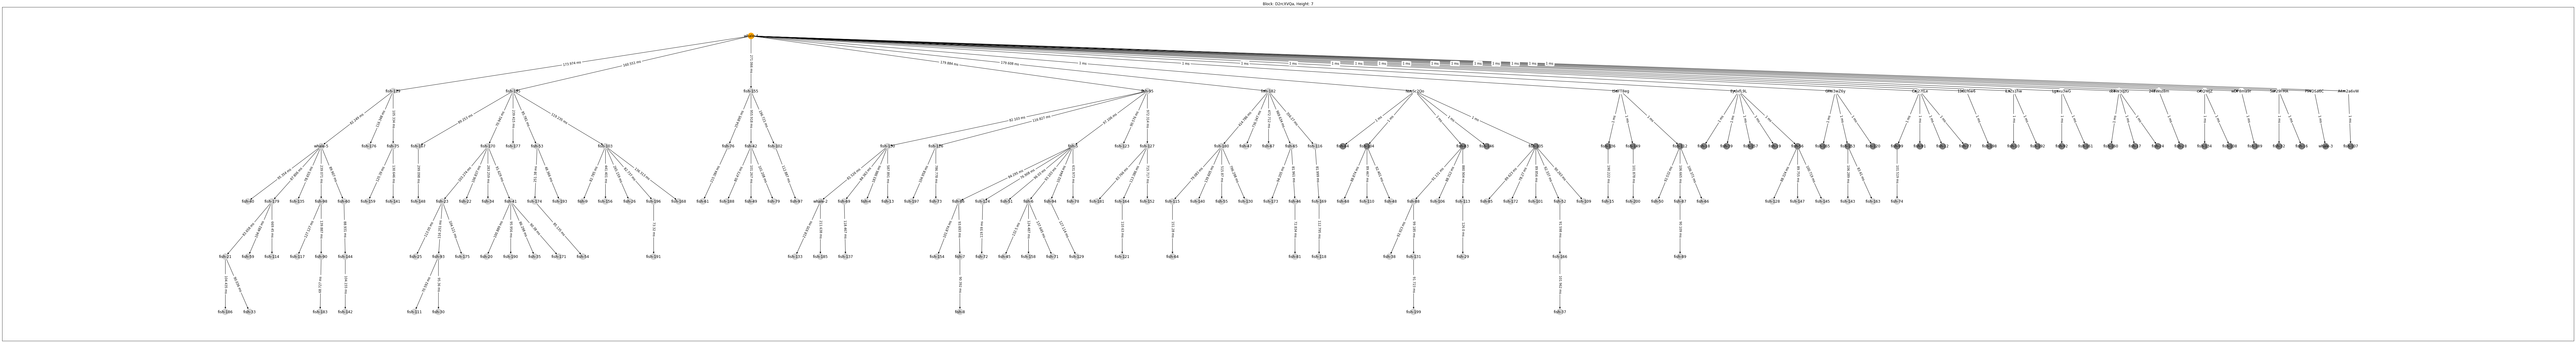

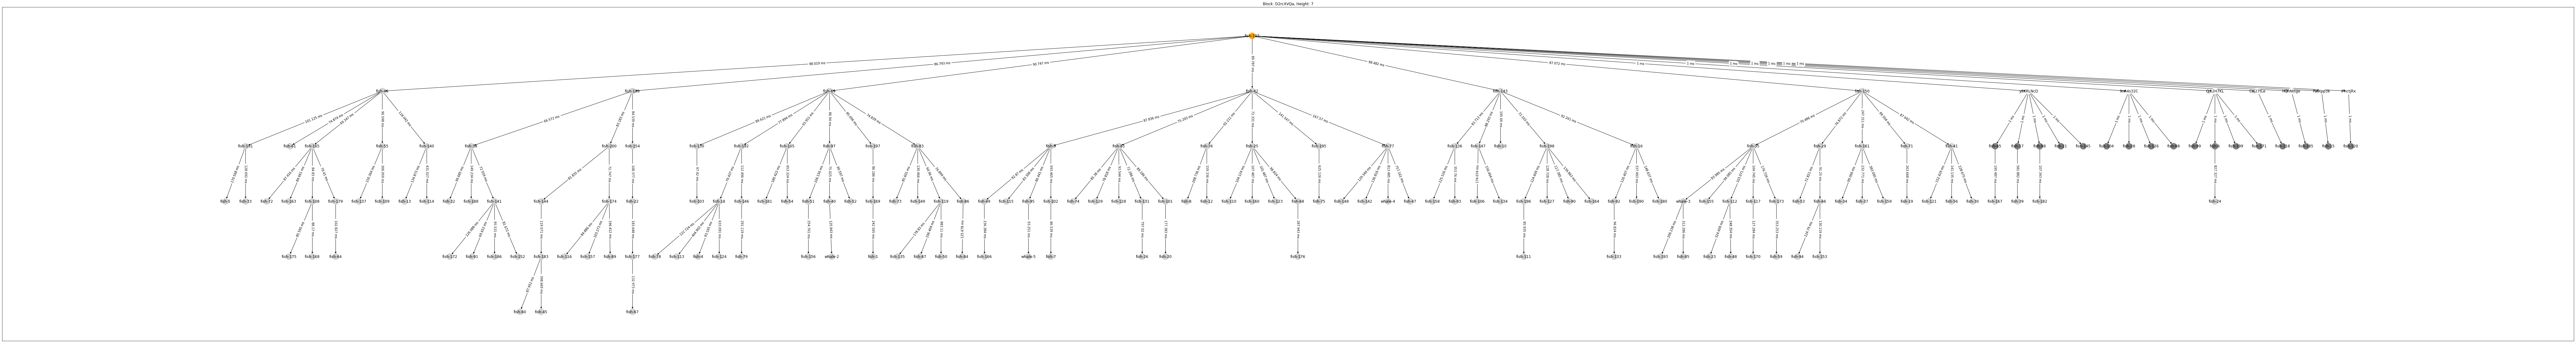

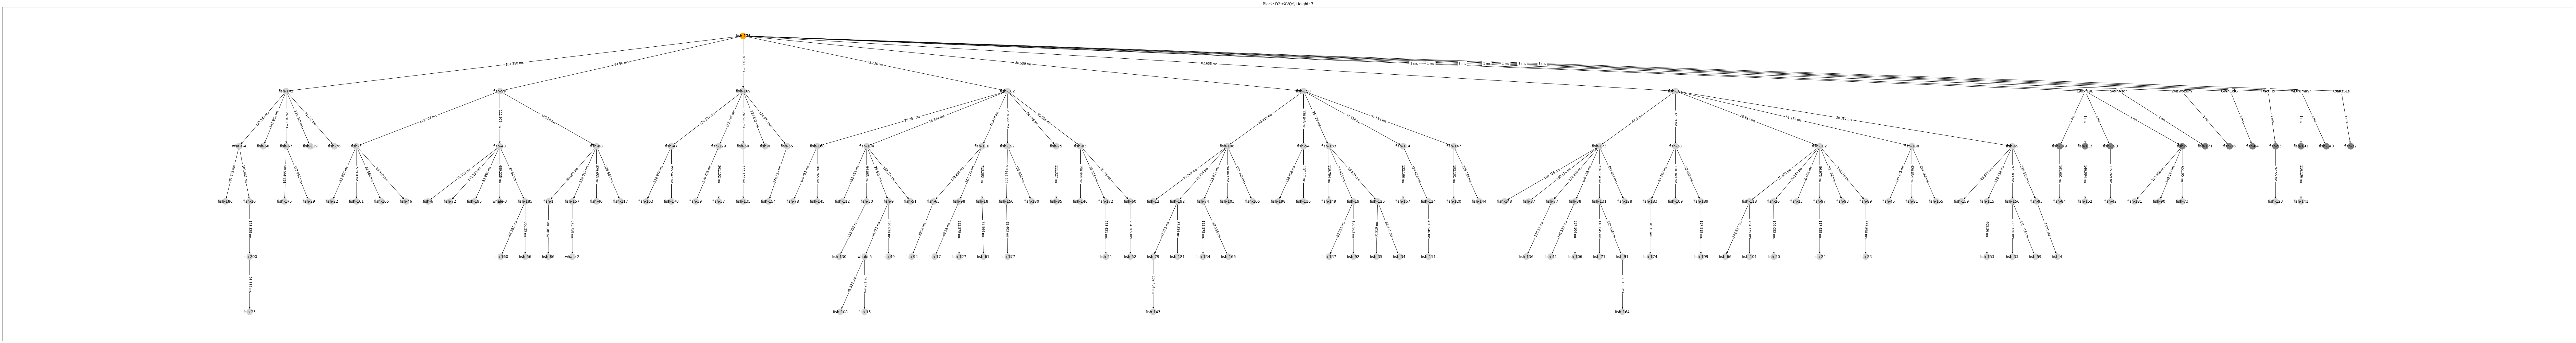

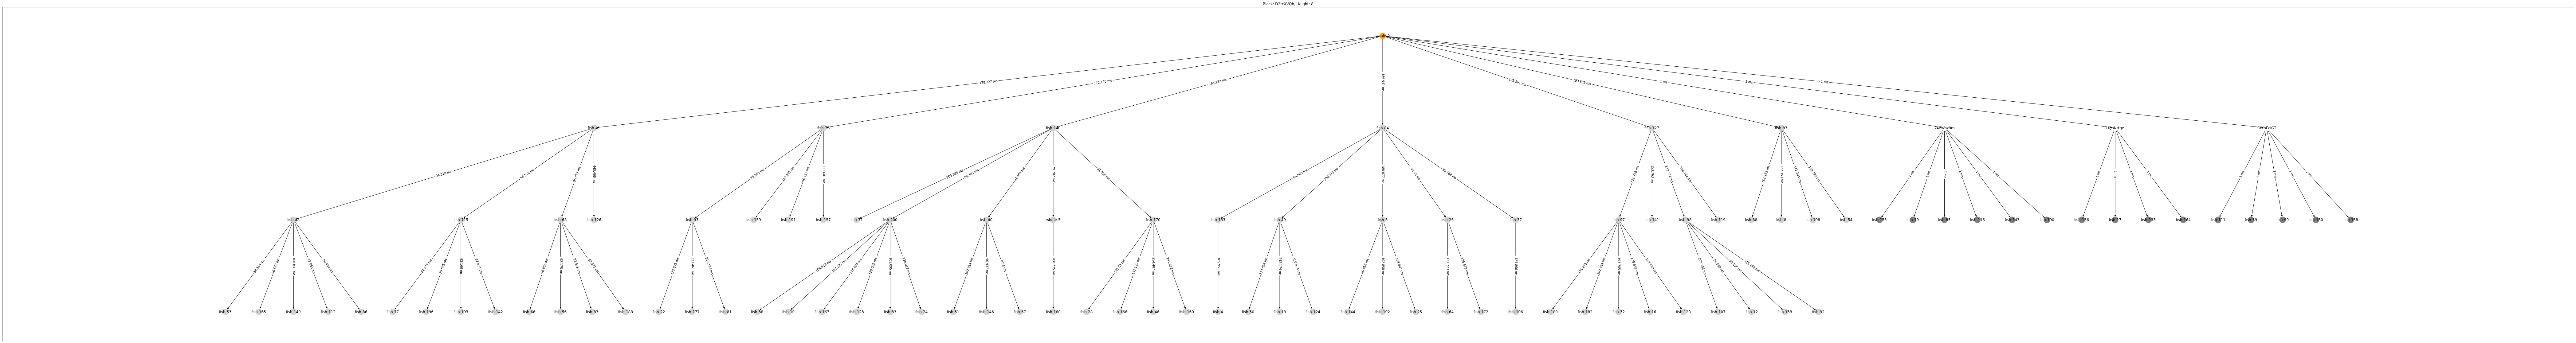

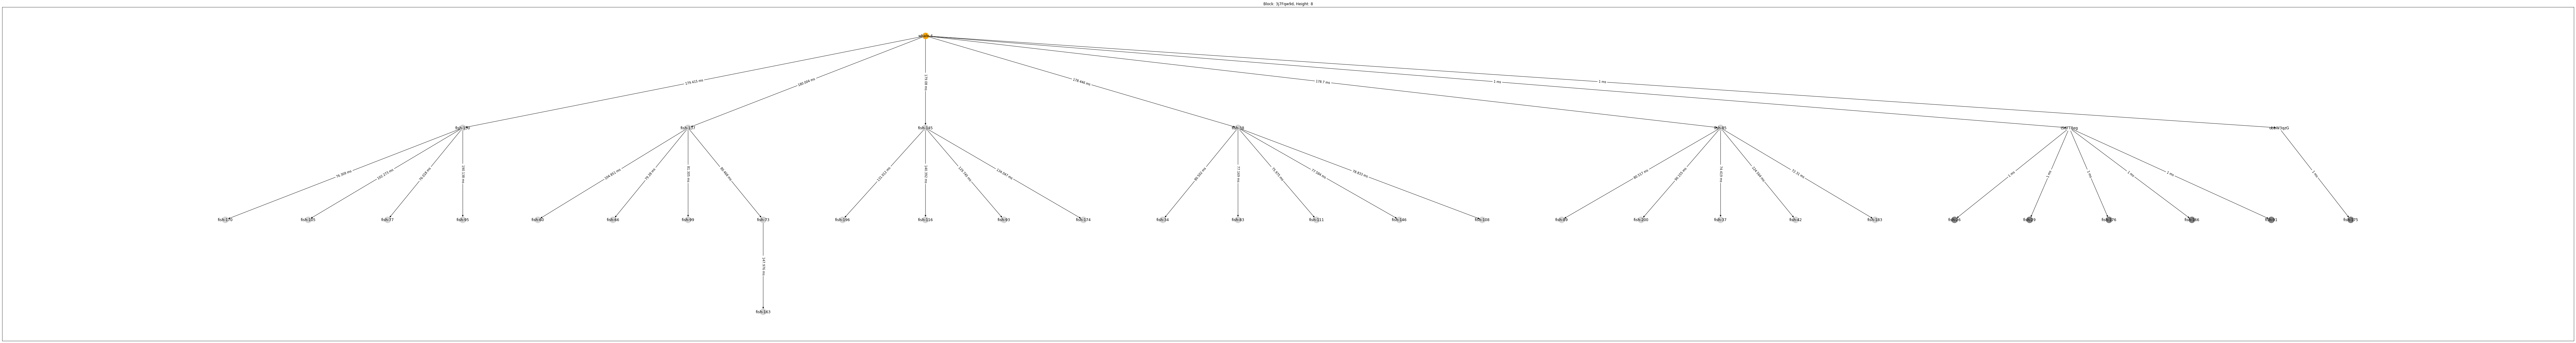

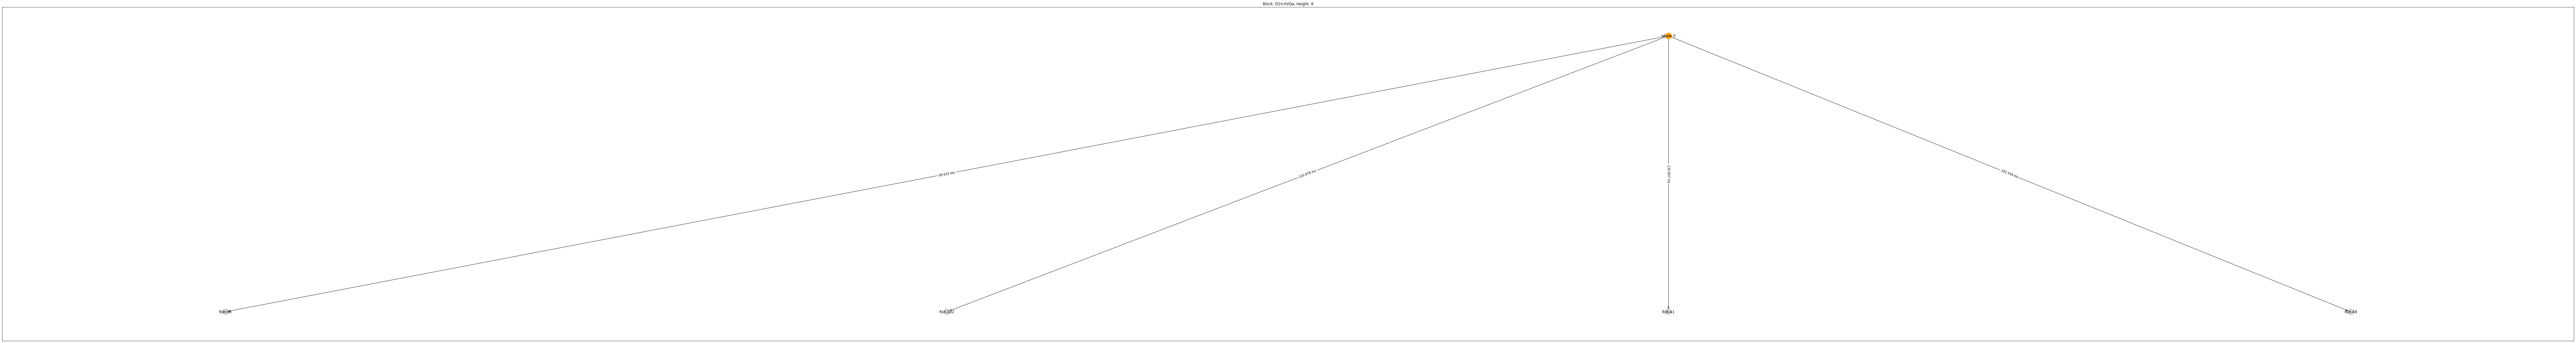

In [60]:
# process Broadcasting block logs for each block
#print(rebroadcasting_block_logs.keys())
nFigs = 0
for index, key in enumerate(rebroadcasting_block_logs.keys()):
    network_graph = nx.DiGraph()
    #print(key)
    #Register the original block broadcast
    root_node = None
    if key in broadcasting_block_logs:
        for entry in broadcasting_block_logs[key]:
            message = entry["message"]
            metadata = entry["metadata"]
            state_hash = metadata["state_hash"]
            peer_id = metadata["peer_id"]

            # Mark the originator node as the block creator
            network_graph.add_node(peer_id, color="orange", label=entry["k8s-pod/app"].replace("-block-producer-", "-"))
            root_node = peer_id
    else: 
        continue

    # Build all the edges
    if key in received_block_logs:
        for receive_log in received_block_logs[key]:
            message = receive_log["message"]
            metadata = receive_log["metadata"]
            state_hash = metadata["state_hash"]

            sender = metadata["sender"]["Remote"]
            receiver = {
                "host": metadata["host"],
                "peer_id": metadata["peer_id"]
            }

            # Get corresponding Broadcast or Rebroadcast log
            if key in broadcasting_block_logs:
                broadcast_log = retrieve_log(broadcasting_block_logs[key], "peer_id", sender["peer_id"])
            else:
                broadcast_log = None
            if key in rebroadcasting_block_logs:
                rebroadcast_log = retrieve_log(rebroadcasting_block_logs[key], "peer_id", sender["peer_id"])
            else: 
                rebroadcast_log = None
            #   i.e. a rebroadcast log with the current `state_hash` and the sender's peer_id
            # if it exists, edge_weight = received_timestamp - broadcast_timestamp
            import dateutil.parser

            if broadcast_log:
                send_time = broadcast_log["timestamp"]
                #print("Broadcast Log")
            elif rebroadcast_log:
                send_time = rebroadcast_log["timestamp"]
                #print("Rebroadcast Log")
            else:
                # No log found, can't make an edge
                #print("No Sender log found...")
                if sender["peer_id"] not in network_graph:
                    network_graph.add_node(sender["peer_id"], color="white", label=sender["peer_id"][-8:])
                    # Connect this node with a dotted line to the seed node 
                    network_graph.add_edge(root_node, sender["peer_id"], color="orange", weight=1)
                if receiver["peer_id"] not in network_graph:
                    #print(receive_log["k8s-pod/app"].replace("-block-producer-", "-"))
                    network_graph.add_node(receiver["peer_id"], color="gray", label=receive_log["k8s-pod/app"].replace("-block-producer-", "-"))
                network_graph.add_edge(sender["peer_id"], receiver["peer_id"], weight=1)
                continue

            send_datetime = dateutil.parser.isoparse(send_time)
            receive_datetime = dateutil.parser.isoparse(receive_log["timestamp"])

            edge_weight = (receive_datetime - send_datetime).microseconds / 1000

            network_graph.add_node(receiver["peer_id"], color="#D3D3D3", label=receive_log["k8s-pod/app"].replace("-block-producer-", "-"))
            network_graph.add_edge(sender["peer_id"], receiver["peer_id"], weight=edge_weight)

            # print(f"Sender: {sender['peer_id']}")
            # print(f"Receiver: {receiver['peer_id']}")
            # print(f"Sent: {send_datetime}")
            # print(f"Rece: {receive_datetime}")
            # print(edge_weight)
    else: 
        continue


    edges = network_graph.edges()
    edgelist = []
    for u,v in edges:
        edgelist.append((u,v))
    #print (edgelist)
    color_map = []
    for node in network_graph.nodes(data=True):
        if "color" in node[1]:
            color_map.append(node[1]["color"])
        else:
            color_map.append("blue")
    labels = nx.get_node_attributes(network_graph, 'label') 

    weights = [network_graph[u][v]['weight'] for u,v in list(edgelist)]
    degree = network_graph.degree()



    blockchain_length = broadcasting_block_logs[key][0]["metadata"]["message"][1]["protocol_state"]["body"]["consensus_state"]["blockchain_length"]
    pos=nx.nx_agraph.graphviz_layout(network_graph, prog="dot", args="-Nk=30")
    plt.figure(figsize=(150,20))
    plt.title(f"Block: {key[0:8]}, Height: {blockchain_length}")
    nx.draw_networkx(network_graph, pos, node_color=color_map, node_size=400, labels=labels, font_color="black")
    edge_labels=dict([((u,v,),str(d['weight']) + " ms")
     for u,v,d in network_graph.edges(data=True)])
    nx.draw_networkx_edge_labels(network_graph, pos, edge_labels=edge_labels)
    nFigs += 1
    print(nFigs)
    if nFigs == 30:
        break
plt.show()